#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

In [4]:
df=pd.read_csv('final data.csv')
print(df.shape)
df.head()

(488849, 134)


,Injury Severity,Crash_Month,Crash_Day,Crash_Minute,Crash_AM/PM,Crash_Hour,Unit_Nbr,Prsn_Age,Toll_Road_Fl,Crash_Speed_Limit,...,Traffic_Cntl_ID_STOP SIGN,Traffic_Cntl_ID_WARNING SIGN,Traffic_Cntl_ID_YIELD SIGN,Unit_Desc_ID_MOTORIZED CONVEYANCE,Unit_Desc_ID_NON-CONTACT,Unit_Desc_ID_OTHER (EXPLAIN IN NARRATIVE),Unit_Desc_ID_PEDALCYCLIST,Unit_Desc_ID_PEDESTRIAN,Unit_Desc_ID_TOWED/PUSHED/TRAILER,Unit_Desc_ID_TRAIN
0,INCAPACITATING INJURY,7,20,37,0,3,3,26,0,55,...,0,0,0,0,0,0,0,0,0,0
1,KILLED,7,27,45,0,11,3,61,0,75,...,0,0,0,0,0,0,0,0,0,0
2,KILLED,8,10,5,1,5,2,55,0,55,...,0,0,0,0,0,0,0,0,0,0
3,KILLED,7,21,17,1,6,2,84,0,65,...,0,0,0,0,0,0,0,0,0,0
4,KILLED,8,27,26,0,7,2,78,0,75,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y=np.where(df['Injury Severity']=='KILLED',1,0)
y

array([0, 1, 1, ..., 0, 0, 0])

In [6]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 488849
    Positive: 1494 (0.31% of total)



In [7]:
X=df.iloc[:,1:].copy()
X

,Crash_Month,Crash_Day,Crash_Minute,Crash_AM/PM,Crash_Hour,Unit_Nbr,Prsn_Age,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,...,Traffic_Cntl_ID_STOP SIGN,Traffic_Cntl_ID_WARNING SIGN,Traffic_Cntl_ID_YIELD SIGN,Unit_Desc_ID_MOTORIZED CONVEYANCE,Unit_Desc_ID_NON-CONTACT,Unit_Desc_ID_OTHER (EXPLAIN IN NARRATIVE),Unit_Desc_ID_PEDALCYCLIST,Unit_Desc_ID_PEDESTRIAN,Unit_Desc_ID_TOWED/PUSHED/TRAILER,Unit_Desc_ID_TRAIN
0,7,20,37,0,3,3,26,0,55,0,...,0,0,0,0,0,0,0,0,0,0
1,7,27,45,0,11,3,61,0,75,0,...,0,0,0,0,0,0,0,0,0,0
2,8,10,5,1,5,2,55,0,55,0,...,0,0,0,0,0,0,0,0,0,0
3,7,21,17,1,6,2,84,0,65,0,...,0,0,0,0,0,0,0,0,0,0
4,8,27,26,0,7,2,78,0,75,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488844,11,29,13,0,11,1,68,0,70,0,...,0,0,0,0,0,0,0,0,0,0
488845,11,25,6,0,11,1,44,0,55,0,...,1,0,0,0,0,0,0,0,0,0
488846,11,25,6,0,11,2,57,0,55,0,...,1,0,0,0,0,0,0,0,0,0
488847,9,3,15,1,4,1,16,0,40,0,...,1,0,0,0,0,0,0,0,0,0


This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df,train_labels,test_labels  = train_test_split(X,y, test_size=0.2,stratify=y, random_state=48)
train_df, val_df,train_labels,val_labels = train_test_split(train_df,train_labels, test_size=0.2,stratify=train_labels, random_state=48)

# Form np arrays of labels and features.
bool_train_labels = train_labels != 0

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (312863,)
Validation labels shape: (78216,)
Test labels shape: (97770,)
Training features shape: (312863, 133)
Validation features shape: (78216, 133)
Test features shape: (97770, 133)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the ditributions?
    * Yes the positive examples contain a much higher rate of extreme values.

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                2144      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [13]:
model.predict(train_features[:10])

array([[0.7467832 ],
       [0.80093735],
       [0.70080477],
       [0.6420795 ],
       [0.8722038 ],
       [0.7577103 ],
       [0.6524761 ],
       [0.7237632 ],
       [0.6766815 ],
       [0.624847  ]], dtype=float32)

### Optional: Set the correct initial bias.

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4753


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.78753572])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [16]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.003805  ],
       [0.00258359],
       [0.00131483],
       [0.00139024],
       [0.00172322],
       [0.00362556],
       [0.0017801 ],
       [0.00158257],
       [0.00237367],
       [0.00124915]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0234


This initial loss is about 50 times less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

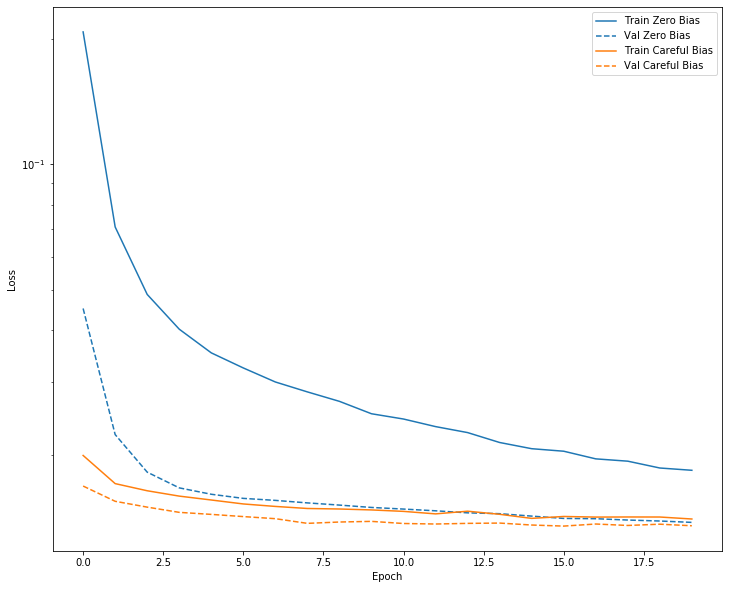

In [22]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 312863 samples, validate on 78216 samples
Epoch 1/100
312863/312863 [==============================] - 7s 22us/sample - loss: 0.0201 - tp: 2.0000 - fp: 8.0000 - tn: 311899.0000 - fn: 954.0000 - accuracy: 0.9969 - precision: 0.2000 - recall: 0.0021 - auc: 0.6425 - val_loss: 0.0166 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77977.0000 - val_fn: 239.0000 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8219
Epoch 2/100
312863/312863 [==============================] - 3s 9us/sample - loss: 0.0169 - tp: 16.0000 - fp: 36.0000 - tn: 311871.0000 - fn: 940.0000 - accuracy: 0.9969 - precision: 0.3077 - recall: 0.0167 - auc: 0.7896 - val_loss: 0.0154 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77977.0000 - val_fn: 239.0000 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8643
Epoch 3/100
312863/312863 [==============================] - 3s 9us/sample - loss: 0.0162 - tp: 20.0000 - fp: 35.0000 

Epoch 00020: early stopping


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [24]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


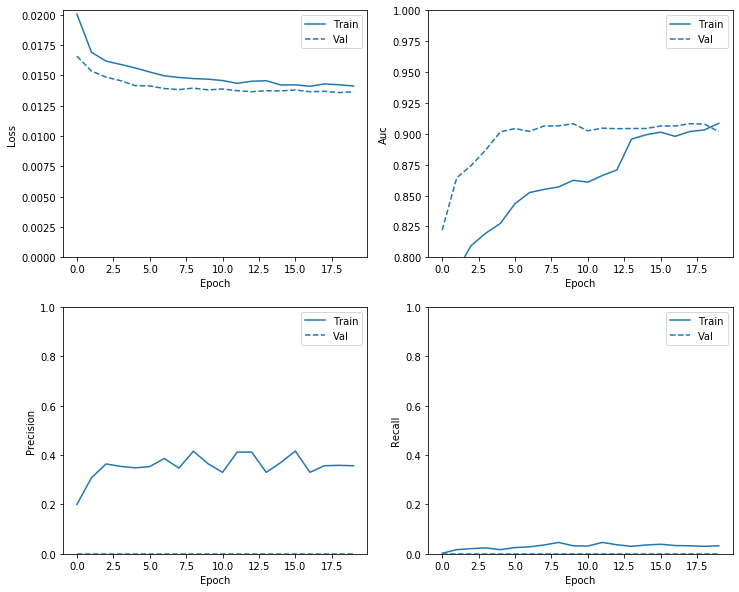

In [25]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [26]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [27]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.013940526736208457
tp :  0.0
fp :  0.0
tn :  97471.0
fn :  299.0
accuracy :  0.9969418
precision :  0.0
recall :  0.0
auc :  0.89212334

Legitimate Transactions Detected (True Negatives):  97471
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  299
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  299


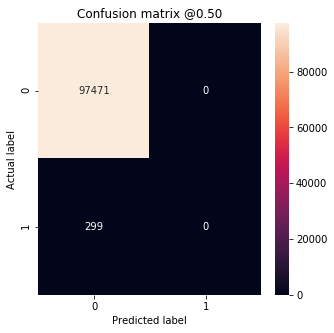

In [28]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

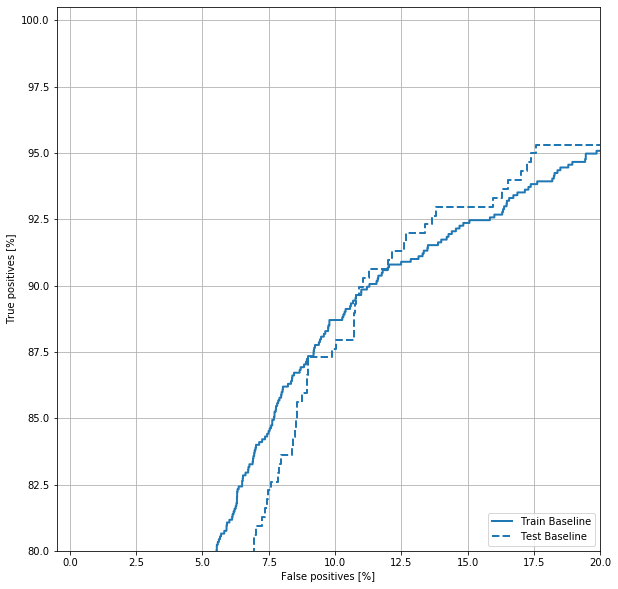

In [30]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [31]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 163.60


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [32]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 312863 samples, validate on 78216 samples
Epoch 1/100
312863/312863 [==============================] - 7s 22us/sample - loss: 2.3557 - tp: 67.0000 - fp: 1013.0000 - tn: 310894.0000 - fn: 889.0000 - accuracy: 0.9939 - precision: 0.0620 - recall: 0.0701 - auc: 0.6507 - val_loss: 1.2097 - val_tp: 46.0000 - val_fp: 298.0000 - val_tn: 77679.0000 - val_fn: 193.0000 - val_accuracy: 0.9937 - val_precision: 0.1337 - val_recall: 0.1925 - val_auc: 0.8850
Epoch 2/100
312863/312863 [==============================] - 3s 8us/sample - loss: 1.0892 - tp: 395.0000 - fp: 13566.0000 - tn: 298341.0000 - fn: 561.0000 - accuracy: 0.9548 - precision: 0.0283 - recall: 0.4132 - auc: 0.8152 - val_loss: 0.4989 - val_tp: 162.0000 - val_fp: 4054.0000 - val_tn: 73923.0000 - val_fn: 77.0000 - val_accuracy: 0.9472 - val_precision: 0.0384 - val_recall: 0.6778 - val_auc: 0.9244
Epoch 3/100
312863/312863 [==============================] - 3s 9us/sample - loss: 0.

### Check training history

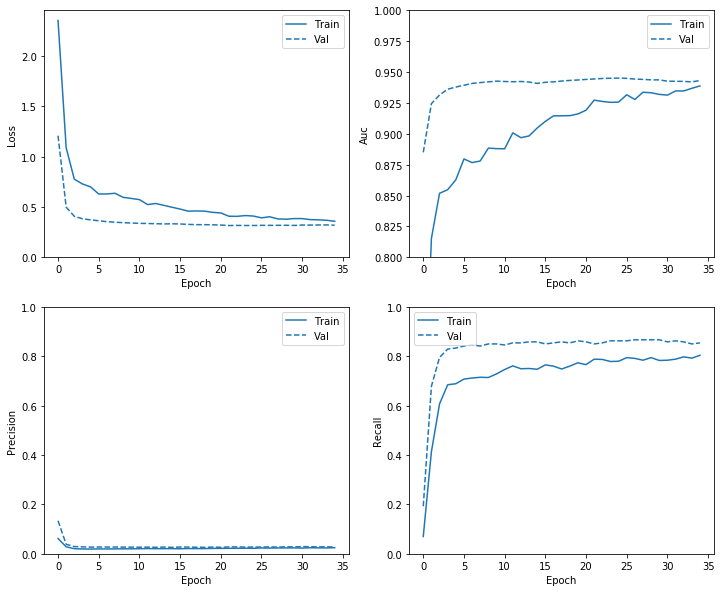

In [33]:
plot_metrics(weighted_history)

### Evaluate metrics

In [34]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.2946148797170119
tp :  263.0
fp :  9384.0
tn :  88087.0
fn :  36.0
accuracy :  0.9036514
precision :  0.027262362
recall :  0.8795987
auc :  0.95506305

Legitimate Transactions Detected (True Negatives):  88087
Legitimate Transactions Incorrectly Detected (False Positives):  9384
Fraudulent Transactions Missed (False Negatives):  36
Fraudulent Transactions Detected (True Positives):  263
Total Fraudulent Transactions:  299


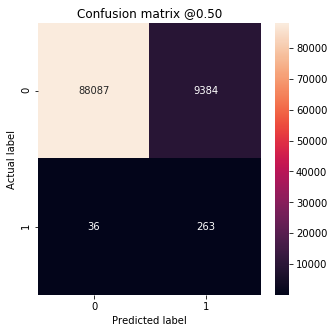

In [35]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade offs between these different types of errors for your application.

### Plot the ROC

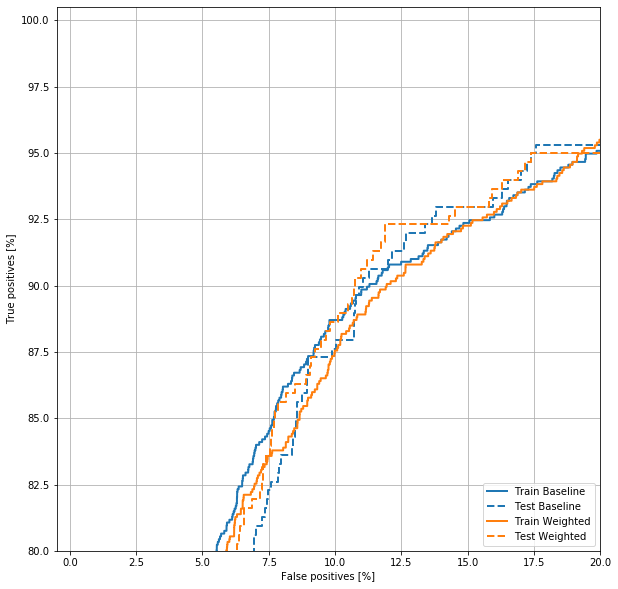

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [37]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [38]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(311907, 133)

In [39]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(623814, 133)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [40]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [41]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-3.24381510e-01  2.54344148e-01  1.34895708e+00 -1.41009097e+00
 -1.33483351e+00  5.89727148e-01 -7.30173829e-01 -1.34337308e-01
 -2.29532938e-01 -2.28610698e-01 -1.30728894e-01  1.38023796e+00
 -3.97913228e-01  8.77974729e-01 -4.13155298e-01 -3.83692800e-01
  3.06689970e+00 -4.23336022e-01 -4.24956897e-01 -4.26135635e-01
  5.00000000e+00 -4.94117125e-02 -3.57565550e-03 -5.28064778e-02
 -7.84560401e-02 -3.21475927e-02 -1.81473414e-02  1.06672184e-01
 -2.74170040e-02 -1.28931983e-02 -7.99561321e-03 -2.13091266e-02
 -5.65366196e-03 -9.59149288e-02 -1.78781918e-03 -3.09660355e-03
 -3.09660355e-03 -1.78781918e-03 -1.75196390e-02 -1.95186976e-01
  2.21978745e+00 -7.39307633e-01 -1.37423847e-01 -8.51647242e-01
  8.59542694e-01 -1.63878073e-02  5.00000000e+00 -4.76919871e-02
 -1.77913629e-02 -2.70483415e-01 -1.47443135e-02 -1.44729855e-01
 -1.91101052e+00  5.00000000e+00 -7.22347222e-02 -2.47803144e-02
 -4.68086600e-02  5.00000000e+00 -3.10839411e-02 -1.90921334e-02
 -3.97272772e-

Merge the two together using `experimental.sample_from_datasets`:

In [42]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [43]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.501953125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [44]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

476.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [45]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 476.0 steps, validate for 39 steps
Epoch 1/100
476/476 [==============================] - 36s 75ms/step - loss: 0.4105 - tp: 380835.0000 - fp: 77635.0000 - tn: 409703.0000 - fn: 106675.0000 - accuracy: 0.8109 - precision: 0.8307 - recall: 0.7812 - auc: 0.8965 - val_loss: 0.2632 - val_tp: 210.0000 - val_fp: 8211.0000 - val_tn: 69766.0000 - val_fn: 29.0000 - val_accuracy: 0.8947 - val_precision: 0.0249 - val_recall: 0.8787 - val_auc: 0.947797256.0000 - accuracy: 0.7989 - precis - ETA: 3s - loss: 0.4206 - tp: 342986.0000 - fp: 72416.0000 - tn: 371920.0000 - f
Epoch 2/100
476/476 [==============================] - 28s 58ms/step - loss: 0.2810 - tp: 442044.0000 - fp: 59664.0000 - tn: 427777.0000 - fn: 45363.0000 - accuracy: 0.8923 - precision: 0.8811 - recall: 0.9069 - auc: 0.9529 - val_loss: 0.2278 - val_tp: 206.0000 - val_fp: 7816.0000 - val_tn: 70161.0000 - val_fn: 33.0000 - val_accuracy: 0.8996 - val_precision: 0.0257 - val_recall: 0.8619 - val_auc: 0.9464
Epoch 3/100
476/476 

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

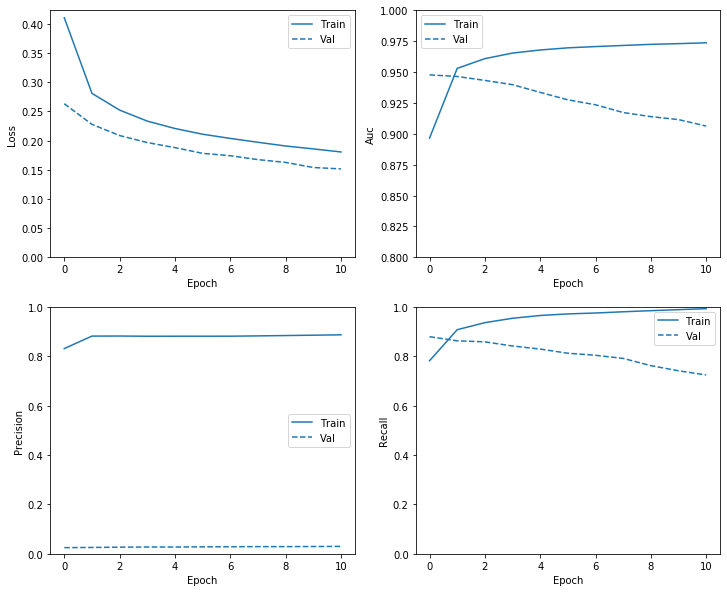

In [46]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [47]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 39 steps
Epoch 1/1000
20/20 [==============================] - 7s 355ms/step - loss: 0.9092 - tp: 6740.0000 - fp: 5356.0000 - tn: 15063.0000 - fn: 13801.0000 - accuracy: 0.5323 - precision: 0.5572 - recall: 0.3281 - auc: 0.5052 - val_loss: 0.5148 - val_tp: 116.0000 - val_fp: 15936.0000 - val_tn: 62041.0000 - val_fn: 123.0000 - val_accuracy: 0.7947 - val_precision: 0.0072 - val_recall: 0.4854 - val_auc: 0.6786
Epoch 2/1000
20/20 [==============================] - 2s 80ms/step - loss: 0.6628 - tp: 11845.0000 - fp: 5939.0000 - tn: 14533.0000 - fn: 8643.0000 - accuracy: 0.6440 - precision: 0.6660 - recall: 0.5781 - auc: 0.6841 - val_loss: 0.5350 - val_tp: 183.0000 - val_fp: 17806.0000 - val_tn: 60171.0000 - val_fn: 56.0000 - val_accuracy: 0.7716 - val_precision: 0.0102 - val_recall: 0.7657 - val_auc: 0.8378
Epoch 3/1000
20/20 [==============================] - 2s 84ms/step - loss: 0.5646 - tp: 14376.0000 - fp: 5841.0000 - tn: 14728.0000 - fn: 6015.0000 - ac

20/20 [==============================] - 2s 100ms/step - loss: 0.2733 - tp: 18717.0000 - fp: 2552.0000 - tn: 17974.0000 - fn: 1717.0000 - accuracy: 0.8958 - precision: 0.8800 - recall: 0.9160 - auc: 0.9548 - val_loss: 0.2359 - val_tp: 209.0000 - val_fp: 7995.0000 - val_tn: 69982.0000 - val_fn: 30.0000 - val_accuracy: 0.8974 - val_precision: 0.0255 - val_recall: 0.8745 - val_auc: 0.9476
Epoch 42/1000
20/20 [==============================] - 2s 79ms/step - loss: 0.2672 - tp: 18597.0000 - fp: 2482.0000 - tn: 18215.0000 - fn: 1666.0000 - accuracy: 0.8987 - precision: 0.8823 - recall: 0.9178 - auc: 0.9571 - val_loss: 0.2329 - val_tp: 208.0000 - val_fp: 7896.0000 - val_tn: 70081.0000 - val_fn: 31.0000 - val_accuracy: 0.8987 - val_precision: 0.0257 - val_recall: 0.8703 - val_auc: 0.9467
Epoch 00042: early stopping


### Re-check training history

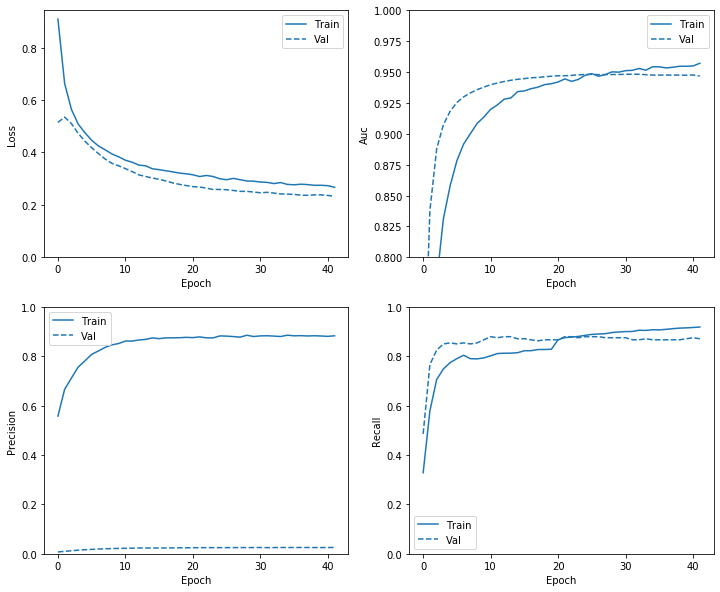

In [48]:
plot_metrics(resampled_history)

### Evaluate metrics

In [49]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.25125396861502813
tp :  266.0
fp :  10286.0
tn :  87185.0
fn :  33.0
accuracy :  0.8944564
precision :  0.025208492
recall :  0.8896321
auc :  0.95630723

Legitimate Transactions Detected (True Negatives):  87185
Legitimate Transactions Incorrectly Detected (False Positives):  10286
Fraudulent Transactions Missed (False Negatives):  33
Fraudulent Transactions Detected (True Positives):  266
Total Fraudulent Transactions:  299


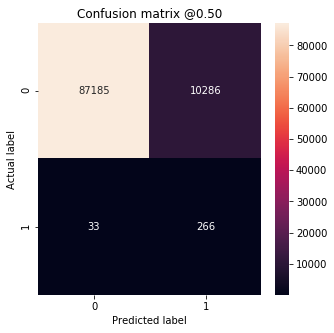

In [50]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

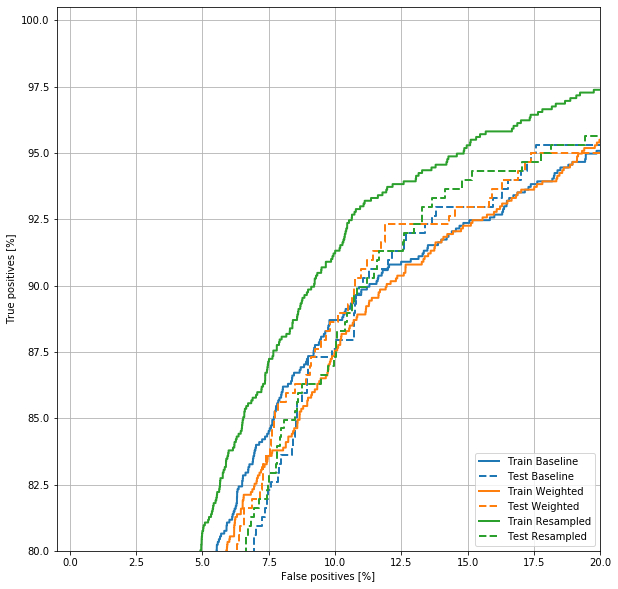

In [51]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.